**Ekstraksi Fitur Citra Lengkap**
===
---
**Author :** *Muhammad Wira Widhana*

In [ ]:
pip install opencv-python numpy matplotlib scikit-image scikit-learn tensorflow

Disini saya mengekstrak sekitar 11 data dan saya mencoba menggunakan tensorflow


Fitur Tradisional

* Geometris: Luas Area, Keliling

* Tekstur: Kontras, Korelasi (GLCM)

* Warna: Rata-rata & Deviasi Standar RGB

* Bentuk: 7 Momen Hu

Fitur CNN

* Vektor 1280-dimensi (MobileNetV2)

Metadata

* Resolusi Gambar

* Jumlah Saluran Warna



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os


# SETUP OUTPUT FOLDER
output_dir = "Output"
os.makedirs(output_dir, exist_ok=True)


# 1. memasukan Gambar & Validasi

def load_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Gagal membaca gambar {img_path}")
    return img

try:
    image = load_image('apel-merah-dan-apel-hijau.jpg')
    original = image.copy()
    cv2.imwrite(os.path.join(output_dir, "00_original.jpg"), cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
except Exception as e:
    print("ERROR:", str(e))
    exit()



In [3]:

# 2. OPERASI DASAR PENGOLAHAN CITRA 
def save_step(img, filename, cmap=None):
    cv2.imwrite(os.path.join(output_dir, filename), img)

# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
save_step(gray, "01_grayscale.jpg")

# Brightness (+50)
bright = cv2.convertScaleAbs(image, alpha=1, beta=50)
save_step(bright, "02_brightness.jpg")

# Contrast (Alpha=1.5)
contrast_img = cv2.convertScaleAbs(image, alpha=1.5, beta=0)  # Diubah nama variabel
save_step(contrast_img, "03_contrast.jpg")

# Thresholding (Otsu)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
save_step(thresh, "04_threshold.jpg")

# Resize (300x300)
resized = cv2.resize(image, (300,300))
save_step(resized, "05_resized.jpg")

# Rotate 45 derajat
(h, w) = image.shape[:2]
center = (w//2, h//2)
M = cv2.getRotationMatrix2D(center, 45, 1.0)
rotated = cv2.warpAffine(image, M, (w, h))
save_step(rotated, "06_rotated.jpg")

# Flip Horizontal
flipped = cv2.flip(image, 1)
save_step(flipped, "07_flipped.jpg")

# Cropping (100:400, 200:500)
cropped = image[100:400, 200:500]
save_step(cropped, "08_cropped.jpg")

# Blurring (Gaussian)
blurred = cv2.GaussianBlur(image, (15,15), 0)
save_step(blurred, "09_blurred.jpg")

# Sharpening
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)
save_step(sharpened, "10_sharpened.jpg")

# Negatif
negative = 255 - image
save_step(negative, "11_negative.jpg")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


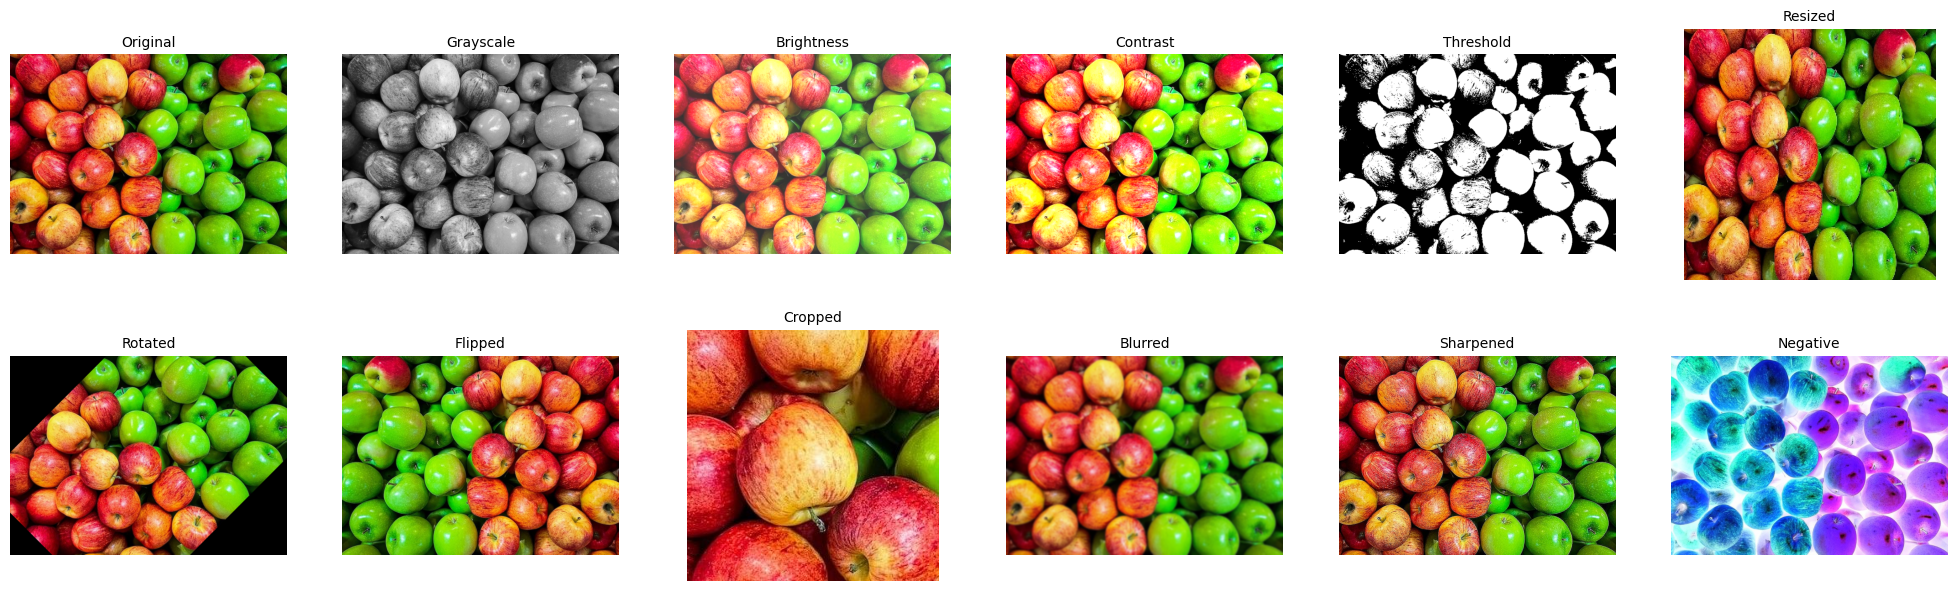

In [4]:
# 3. EKSTRAKSI FITUR
# Fitur Tradisional
glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
texture_contrast = graycoprops(glcm, 'contrast')[0,0]  # Diubah nama variabel
texture_correlation = graycoprops(glcm, 'correlation')[0,0]

# Fitur CNN
def cnn_features(img):
    model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
    img = cv2.resize(img, (224,224))
    img = preprocess_input(img)
    return model.predict(np.expand_dims(img, axis=0)).flatten()

cnn_feat = cnn_features(image)

# 4. VISUALISASI KOMBINASI
plt.figure(figsize=(25,15))

# Operasi Dasar
steps = [
    ("Original", original), ("Grayscale", gray),
    ("Brightness", bright), ("Contrast", contrast_img),  # Gunakan variabel yang benar
    ("Threshold", thresh), ("Resized", resized)
]
for i, (title, img) in enumerate(steps, 1):
    plt.subplot(4,6,i)
    if len(img.shape) == 2:  # Gambar grayscale
        plt.imshow(img, cmap='gray')
    else:  # Gambar warna
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=10)
    plt.axis('off')

# Operasi Geometri
geo_ops = [
    ("Rotated", rotated), ("Flipped", flipped),
    ("Cropped", cropped), ("Blurred", blurred),
    ("Sharpened", sharpened), ("Negative", negative)
]
for i, (title, img) in enumerate(geo_ops, 7):
    plt.subplot(4,6,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=10)
    plt.axis('off')



In [ ]:
# Fitur
plt.subplot(4,6,13)
plt.bar(['Contrast','Correlation'], [texture_contrast, texture_correlation], color=['blue','orange'])
plt.title('Texture Features', fontsize=10)

plt.subplot(4,6,14)
plt.plot(cnn_feat, color='green')
plt.title('CNN Features (1280D)', fontsize=10)

plt.subplot(4,6,15)
plt.hist(image.ravel(), 256, [0,256], color='red')
plt.title('Color Histogram', fontsize=10)

plt.subplot(4,6,16)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.drawContours(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0), 2)
plt.imshow(contour_img)
plt.title('Contour Detection', fontsize=10)
plt.axis('off')

# Penjelasan
plt.subplot(4,6,17)
plt.text(0.1, 0.5, 
         f"ANALYSIS SUMMARY:\n"
         f"Resolution: {original.shape[1]}x{original.shape[0]}\n"
         f"Color Channels: {original.shape[2]}\n"
         f"Texture Contrast: {texture_contrast:.2f}\n"  # Gunakan variabel yang benar
         f"Texture Correlation: {texture_correlation:.2f}\n"
         f"CNN Feature Dim: {len(cnn_feat)}",
         fontsize=12, va='center')
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "12_combined_analysis.png"), dpi=100)
plt.close()

print("Proses selesai! Hasil disimpan di folder Output:")
print("- 00_original.jpg sampai 11_negative.jpg (proses individual)")
print("- 12_combined_analysis.png (gabungan)")